/tmp/ipykernel_35420/4113657501.py:128: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[row_idx, col_idx].set_xlim(min_val, max_val)


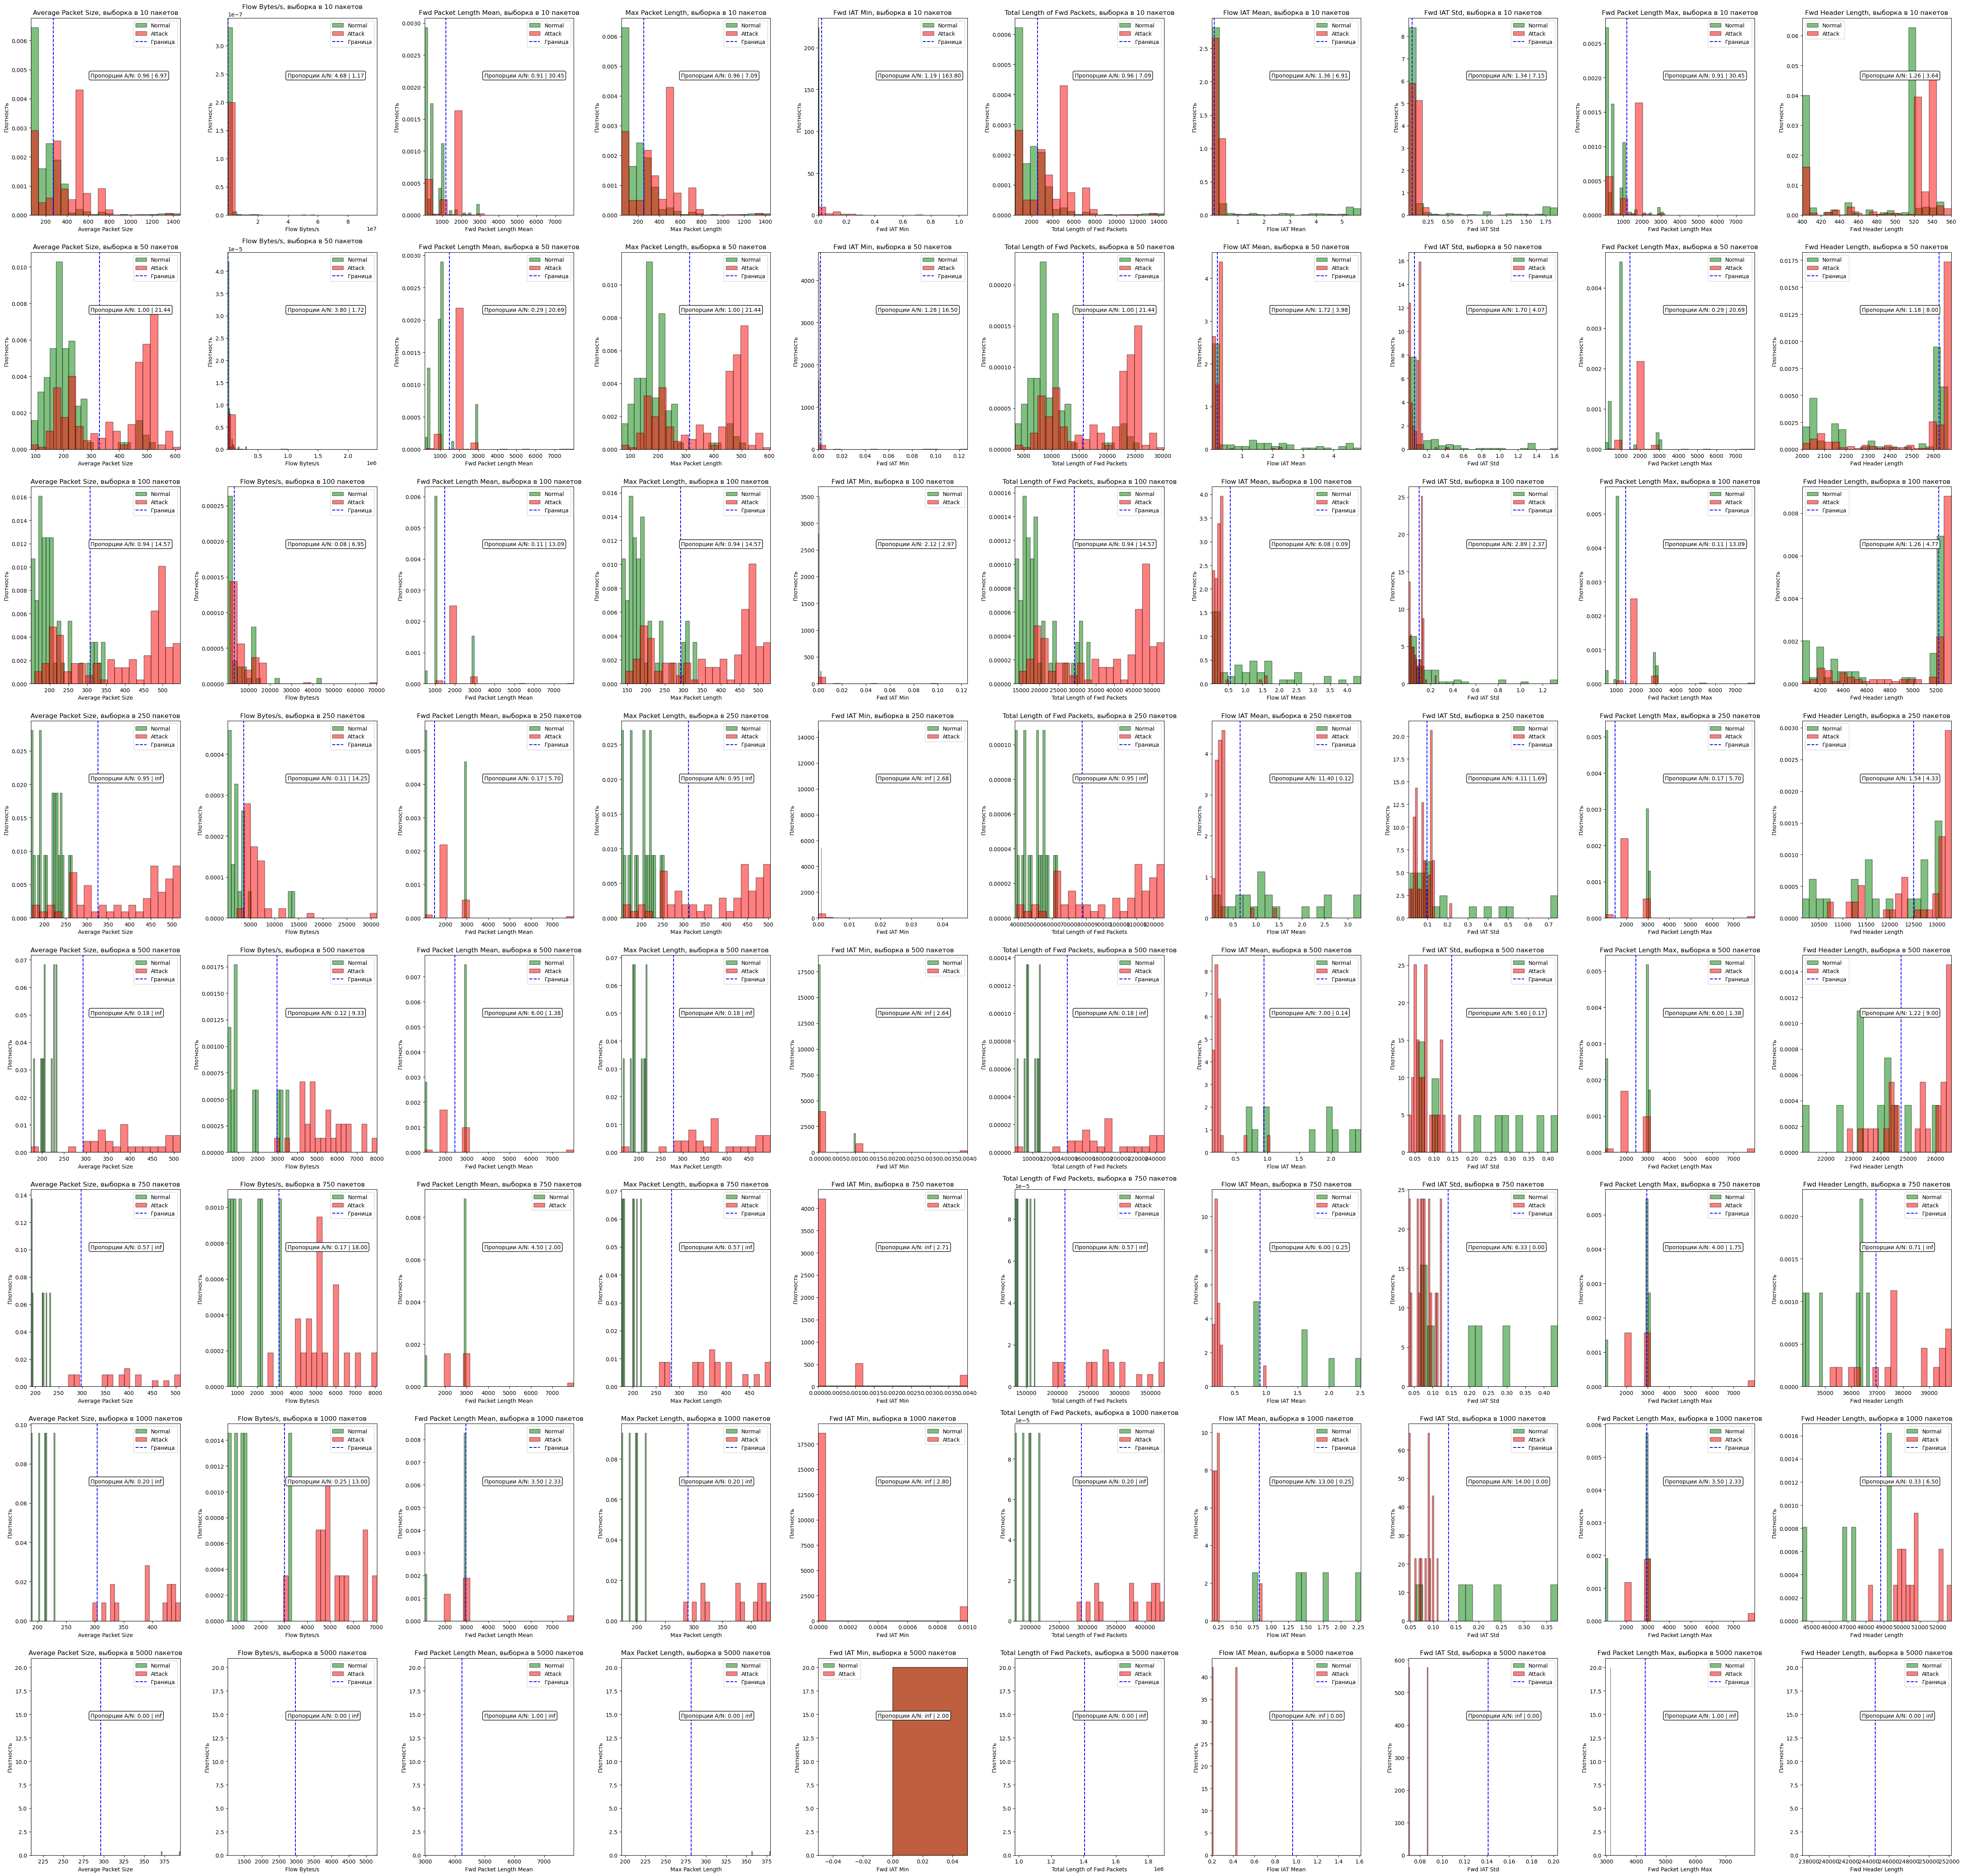

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np


def plot_histograms_for_pairs(attack_dir, normal_dir):
    # Словарь для хранения пар файлов по длине выборки
    pairs = defaultdict(lambda: {"attack": [], "normal": []})

    # Сопоставление файлов из папки attack и normal по длине выборки
    for file in os.listdir(attack_dir):
        if "_1_" in file:
            length = int(file.split("_")[-3])
            pairs[length]["attack"].append(file)

    for file in os.listdir(normal_dir):
        if "_0_" in file:
            length = int(file.split("_")[-3])
            pairs[length]["normal"].append(file)

    # Подсчет общего количества наборов
    total_pairs = 0

    # Определение столбцов на основе первого набора данных
    for length, file_pairs in pairs.items():
        attack_file = sorted(file_pairs["attack"])
        normal_file = sorted(file_pairs["normal"])

        # Убедимся, что количество парных файлов совпадает
        if len(attack_file) == len(normal_file):
            attack_path = os.path.join(attack_dir, attack_file[0])

            # Загрузка данных из файлов CSV
            df_attack = pd.read_csv(attack_path)

            # Получаем список всех столбцов, кроме 'Label' и 'Index'
            columns = [
                col for col in df_attack.columns if col not in ["Label", "Index"]
            ]
            # Считаем, сколько будет строк из горизонтальных подграфиков в итоговом полотне
            total_pairs += 1

    # Создание общего полотна для всех пар файлов
    fig, axes = plt.subplots(
        total_pairs, len(columns), figsize=(5 * len(columns), 6 * total_pairs)
    )

    # Индекс для строк подграфиков
    row_idx = 0

    # Построение графиков для каждого набора пар
    for length, file_pairs in sorted(pairs.items()):
        attack_file = sorted(file_pairs["attack"])
        normal_file = sorted(file_pairs["normal"])

        # Убедимся, что количество парных файлов совпадает
        if len(attack_file) == len(normal_file):
            attack_path = os.path.join(attack_dir, attack_file[0])
            normal_path = os.path.join(normal_dir, normal_file[0])

            # Загрузка данных из файлов CSV
            df_attack = pd.read_csv(attack_path)
            df_normal = pd.read_csv(normal_path)

            # Создание подграфиков в строке
            for col_idx, column in enumerate(columns):
                # Получение минимальных и максимальных значений для нормализации масштаба оси X
                min_val = min(df_normal[column].min(), df_attack[column].min())
                max_val = max(df_normal[column].max(), df_attack[column].max())

                # Построение гистограмм
                hist_normal, bins_normal = np.histogram(
                    df_normal[column], bins=20, density=True
                )
                hist_attack, bins_attack = np.histogram(
                    df_attack[column], bins=20, density=True
                )

                # Вычисление перекрытия
                bin_width_normal = bins_normal[1] - bins_normal[0]
                bin_width_attack = bins_attack[1] - bins_attack[0]

                # Определяем минимальные и максимальные значения для общей гистограммы
                all_bins = np.union1d(bins_normal, bins_attack)
                hist_combined_normal = np.zeros(len(all_bins) - 1)
                hist_combined_attack = np.zeros(len(all_bins) - 1)

                # Переписываем данные гистограмм с учетом общего диапазона
                for i in range(len(bins_normal) - 1):
                    hist_combined_normal[np.digitize(bins_normal[i], all_bins) - 1] += hist_normal[i] * bin_width_normal

                for i in range(len(bins_attack) - 1):
                    hist_combined_attack[np.digitize(bins_attack[i], all_bins) - 1] += hist_attack[i] * bin_width_attack

                # Вычисляем площадь перекрытия
                overlap_area = np.sum(np.minimum(hist_combined_normal, hist_combined_attack))

                # Общая площадь гистограммы атаки
                attack_area = np.sum(hist_combined_attack)

                # Отношение площади перекрытия к площади гистограммы атаки
                ratio_overlap_to_attack = (overlap_area / attack_area) * 100 if attack_area > 0 else 0

                # Отображение гистограмм с границами столбцов
                axes[row_idx, col_idx].hist(
                    df_normal[column],
                    bins=20,
                    color="green",
                    alpha=0.5,
                    label="Normal",
                    density=True,
                    edgecolor="black",
                )
                axes[row_idx, col_idx].hist(
                    df_attack[column],
                    bins=20,
                    color="red",
                    alpha=0.5,
                    label="Attack",
                    density=True,
                    edgecolor="black",
                )

                # Установим общие границы по оси X для нормализации
                axes[row_idx, col_idx].set_xlim(min_val, max_val)
                axes[row_idx, col_idx].set_title(
                    f"{column}, выборка в {length} пакетов"
                )
                axes[row_idx, col_idx].set_xlabel(column)
                axes[row_idx, col_idx].set_ylabel("Плотность")

                # Вычисление медиан и границы
                normal_median = df_normal[column].median()
                attack_median = df_attack[column].median()
                separation_line = (normal_median + attack_median) / 2

                # Подсчет значений атакующего и нормального трафика слева и справа от границы
                left_normal_count = df_normal[
                    df_normal[column] < separation_line
                ].shape[0]
                left_attack_count = df_attack[
                    df_attack[column] < separation_line
                ].shape[0]
                right_normal_count = df_normal[
                    df_normal[column] >= separation_line
                ].shape[0]
                right_attack_count = df_attack[
                    df_attack[column] >= separation_line
                ].shape[0]

                # Подсчет пропорций
                if left_normal_count > 0:
                    left_ratio = left_attack_count / left_normal_count
                else:
                    left_ratio = float(
                        "inf"
                    )  # Если нормального трафика нет, пропорция бесконечна

                if right_normal_count > 0:
                    right_ratio = right_attack_count / right_normal_count
                else:
                    right_ratio = float(
                        "inf"
                    )  # Если нормального трафика нет, пропорция бесконечна

                # # Добавление аннотации о пропорциях
                # axes[row_idx, col_idx].annotate(
                #     f"Лево: {left_attack_count}/{left_normal_count} (Пропорция: {left_ratio:.2f})\n"
                #     f"Право: {right_attack_count}/{right_normal_count} (Пропорция: )",
                #     xy=(0.4, 0.9),
                #     xycoords="axes fraction",
                #     fontsize=10,
                #     bbox=dict(
                #         facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"
                #     ),
                # )

                # Добавление аннотации о проценте перекрытия
                axes[row_idx, col_idx].annotate(
                    # f"Перекрытие: {ratio_overlap_to_attack:.2f}%\n"
                    f"Пропорции A/N: {left_ratio:.2f} | {right_ratio:.2f}",
                    xy=(0.4, 0.7),
                    xycoords="axes fraction",
                    fontsize=10,
                    bbox=dict(
                        facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"
                    ),
                )

                # Добавим линию между медианами, если разница значительная
                if abs(normal_median - attack_median):  # порог можно изменить
                    axes[row_idx, col_idx].axvline(
                        x=separation_line,
                        color="blue",
                        linestyle="--",
                        label="Граница",
                    )

                # Добавление легенды
                axes[row_idx, col_idx].legend()

            row_idx += 1  # Переходим к следующей паре

    # Устанавливаем плотное расположение графиков
    plt.tight_layout()

    # Показать все графики на общем полотне
    plt.show()


# Пример использования функции
attack_dir = "csvs/xss/attack/"
normal_dir = "csvs/xss/normal/"
plot_histograms_for_pairs(attack_dir, normal_dir)